In [1]:
# import libraries
import pandas as pd
from pandas import DataFrame, merge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
# read in the data file
FF1 = pd.read_csv('FoodFuel.csv')

In [3]:
# create datetime 
FF1['Date'] = pd.to_datetime(FF1.Date, utc=True)

In [4]:
# set index to date
FF1.set_index('Date', inplace=True)

In [5]:
# Based on the EDA, I will examine the impact of Ethanol on the following 5 y-variables and compare the effect: Food generally, Meats, Fruits and Vegetables, Rice Pasta Cornmeal and Dairy
FF2 = FF1[['Ethanol','Meats','Food','Fruits and vegetables','Rice, pasta, cornmeal','Dairy and related products']]
FF2.columns = ['Ethanol','Meats','Food','Fruits_veg','Rice_pasta_cornmeal','Dairy']

In [6]:
#calculate year to year shift for sake of stationarity
FFc = FF2 - FF2.shift(12)
FF3 = FFc.iloc[12:]

In [7]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

Ethanol


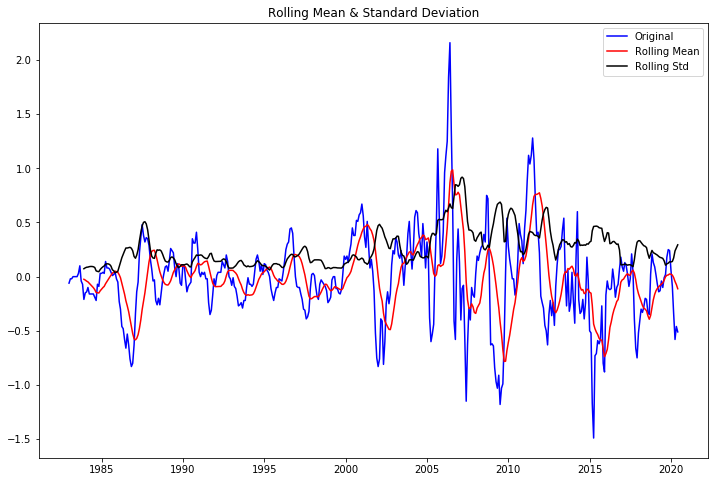

Results of Dickey-Fuller Test for:
Test Statistic                  -4.468985
p-value                          0.000224
#Lags Used                      14.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64
Meats


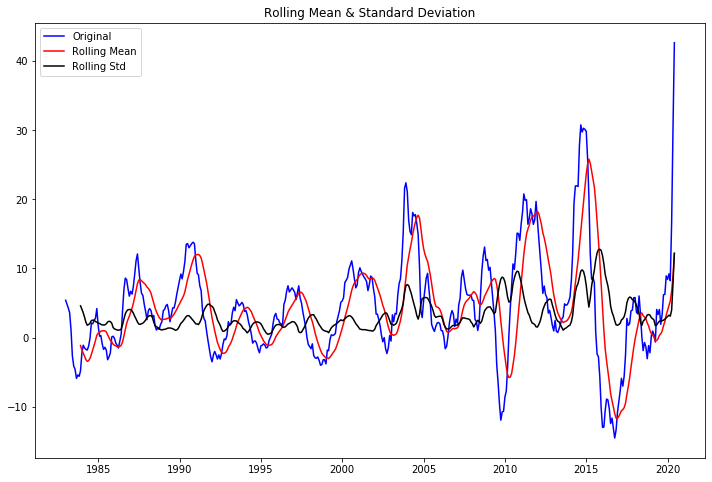

Results of Dickey-Fuller Test for:
Test Statistic                  -3.442433
p-value                          0.009595
#Lags Used                      13.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64
Food


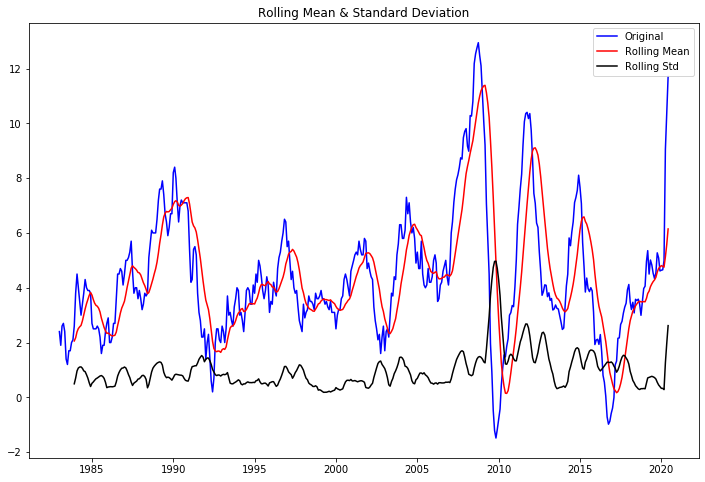

Results of Dickey-Fuller Test for:
Test Statistic                  -4.555883
p-value                          0.000156
#Lags Used                      18.000000
Number of Observations Used    431.000000
Critical Value (1%)             -3.445614
Critical Value (5%)             -2.868269
Critical Value (10%)            -2.570354
dtype: float64
Fruits_veg


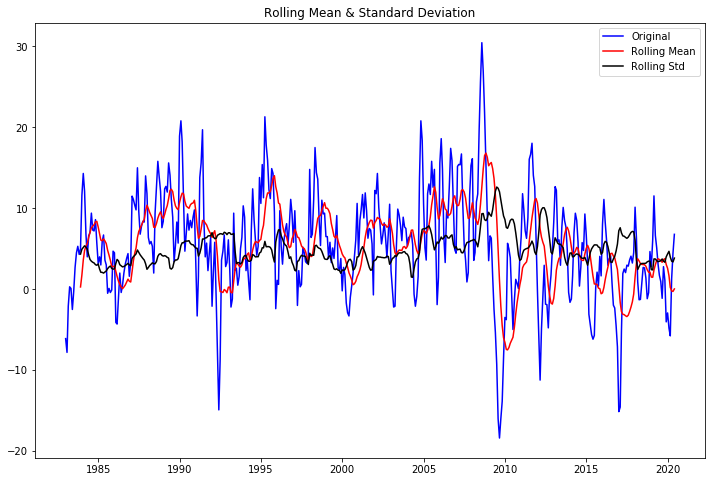

Results of Dickey-Fuller Test for:
Test Statistic                  -4.039423
p-value                          0.001218
#Lags Used                      17.000000
Number of Observations Used    432.000000
Critical Value (1%)             -3.445578
Critical Value (5%)             -2.868254
Critical Value (10%)            -2.570346
dtype: float64
Rice_pasta_cornmeal


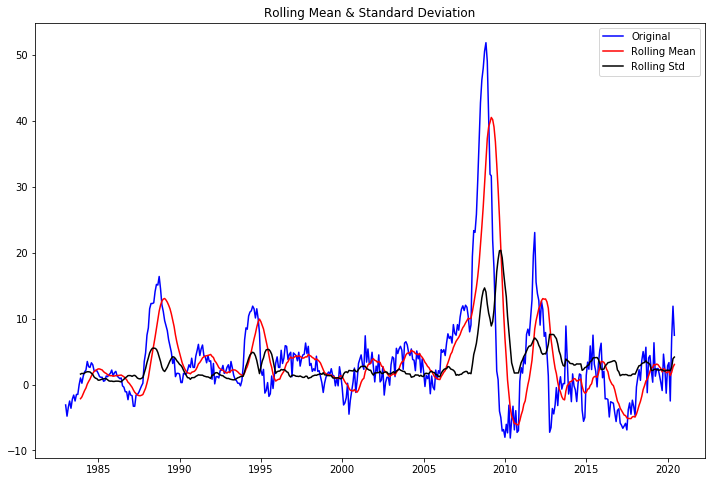

Results of Dickey-Fuller Test for:
Test Statistic                  -4.372158
p-value                          0.000332
#Lags Used                      16.000000
Number of Observations Used    433.000000
Critical Value (1%)             -3.445543
Critical Value (5%)             -2.868238
Critical Value (10%)            -2.570338
dtype: float64
Dairy


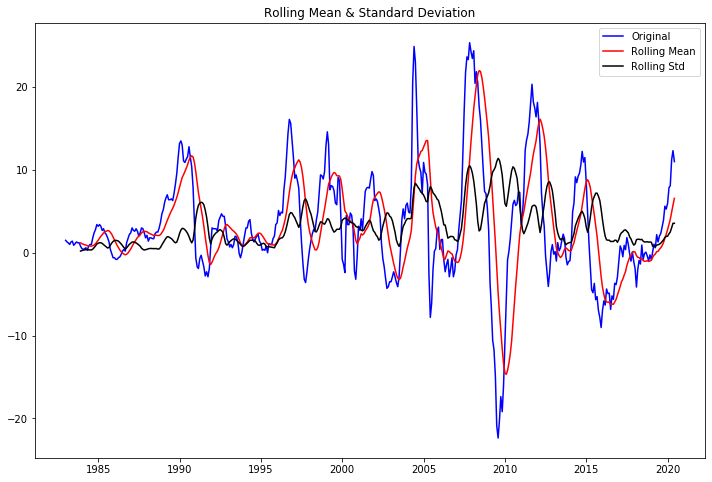

Results of Dickey-Fuller Test for:
Test Statistic                -6.268594e+00
p-value                        4.056288e-08
#Lags Used                     1.700000e+01
Number of Observations Used    4.320000e+02
Critical Value (1%)           -3.445578e+00
Critical Value (5%)           -2.868254e+00
Critical Value (10%)          -2.570346e+00
dtype: float64


In [8]:
# test the stationarity of each variable
for i in FF3.columns:
    print (i)
    test_stationarity(FF3[i])

In [9]:
# Since all variables are stationary with a p value less than 0.05, I will split the time series data 80% train, 20% test - calculate the 80% mark
len(FF3.Ethanol) * 0.8

360.0

In [10]:
# find location of index 360 - Jan 2013
FF3.iloc[360]

Ethanol                0.110
Meats                  0.964
Food                   3.675
Fruits_veg             8.277
Rice_pasta_cornmeal   -4.461
Dairy                 -0.173
Name: 2013-01-01 00:00:00+00:00, dtype: float64

In [11]:
# I will add a constant to be able to run the OLS with a y-intercept
FF3 = sm.add_constant(FF3)

In [12]:
FF3

,const,Ethanol,Meats,Food,Fruits_veg,Rice_pasta_cornmeal,Dairy
Date,,,,,,,
1983-01-01 00:00:00+00:00,1.0,-0.06,5.400,2.400,-6.100,-3.100,1.500
1983-02-01 00:00:00+00:00,1.0,-0.02,4.800,1.900,-7.800,-4.800,1.300
1983-03-01 00:00:00+00:00,1.0,-0.02,4.300,2.600,-2.100,-3.500,1.200
1983-04-01 00:00:00+00:00,1.0,0.00,3.600,2.700,0.300,-2.500,1.000
1983-05-01 00:00:00+00:00,1.0,0.00,1.200,2.400,0.100,-3.600,1.300
...,...,...,...,...,...,...,...
2020-02-01 00:00:00+00:00,1.0,-0.09,9.216,4.654,-4.804,3.337,7.848
2020-03-01 00:00:00+00:00,1.0,-0.34,8.237,4.984,-5.758,-2.496,8.096
2020-04-01 00:00:00+00:00,1.0,-0.58,16.683,9.049,1.306,6.954,11.245


In [13]:
#split into train and test
FFtr = FF3.iloc[:360]
FFts = FF3.iloc[360:]

In [14]:
# scale the variables to visualize them
scaler = preprocessing.StandardScaler()
ethanol_scaled = scaler.fit_transform(FF3[['Ethanol']])
food_scaled = scaler.fit_transform(FF3[['Food']])
meats_scaled = scaler.fit_transform(FF3[['Meats']])
fv_scaled = scaler.fit_transform(FF3[['Fruits_veg']])
rpc_scaled = scaler.fit_transform(FF3[['Rice_pasta_cornmeal']])
dairy_scaled = scaler.fit_transform(FF3[['Dairy']])

In [15]:
# I created a new dataframe to plot each scaled variable against scaled Ethanol to see if they seem to match up visually
Df = FF3.assign(Ethanol_Scaled = ethanol_scaled).assign(Food_scaled = food_scaled).assign(Meats_Scaled = meats_scaled).assign(FV_Scaled = fv_scaled).assign(RPC_Scaled = rpc_scaled).assign(Dairy_Scaled = dairy_scaled)

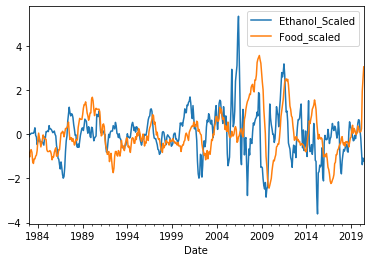

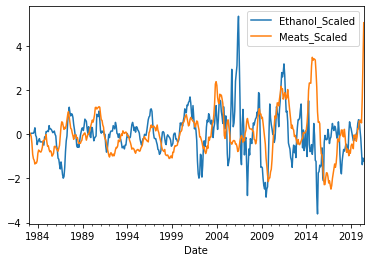

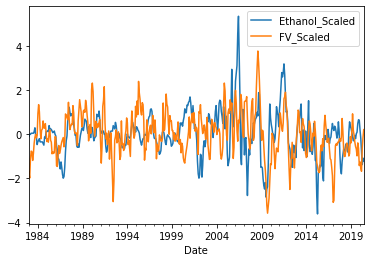

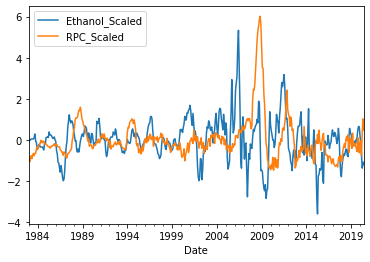

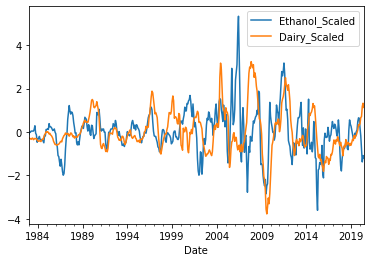

In [16]:
# visualize the relationship with the scaled variables
Df[['Ethanol_Scaled','Food_scaled']].plot()
Df[['Ethanol_Scaled','Meats_Scaled']].plot()
Df[['Ethanol_Scaled','FV_Scaled']].plot()
Df[['Ethanol_Scaled','RPC_Scaled']].plot()
Df[['Ethanol_Scaled','Dairy_Scaled']].plot()

In [17]:
# it seems like there may be a relationship, maybe with a lag. I will run the regression without a lag and then test several lags to see if one fits well.
Regression_Food_Ethanol = sm.OLS(FFtr['Food'],FFtr[['const','Ethanol']]).fit()

In [18]:
Regression_Food_Ethanol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Food   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7.008
Date:                Mon, 07 Sep 2020   Prob (F-statistic):            0.00847
Time:                        14:31:14   Log-Likelihood:                -824.93
No. Observations:                 360   AIC:                             1654.
Df Residuals:                     358   BIC:                             1662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5297      0.127     35.765      0.000       4.281       4.779
Ethanol        0.8103      0.306      2.647      0.008       0.208       1.412
==============================================================================
Omnibus:                       51.575   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.523
Skew:                           0.913   Prob(JB):                     2.42e-17
Kurtosis:                       4.328   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# create y pred
y_pred = Regression_Food_Ethanol.predict(FFts[['Ethanol','const']])

In [20]:
# create empty lists as column names for a soon-to-be created dataframe
el = []
la = []
res = []
rd = []
for i in FFts.columns:
    fr = str(i) + '_pred'
    ie = str(i) + '_test'
    nd = str(i) + '_residuals'
    r_2 = str(i) + '_r2'
    el.append(fr)
    la.append(ie)
    res.append(nd)
    rd.append(r_2)
    

In [21]:
# test to make sure the names are correct
rd

['const_r2',
 'Ethanol_r2',
 'Meats_r2',
 'Food_r2',
 'Fruits_veg_r2',
 'Rice_pasta_cornmeal_r2',
 'Dairy_r2']

In [22]:
# create an empty dictionary to store residuals
resultsd = {}

In [23]:
# loop through the y-variables, regressing each against Ethanol and store the residuals
for i in range(2,7):
    OLSModel = sm.OLS(FFtr.iloc[:,i],FFtr[['const','Ethanol']]).fit()
    rr = OLSModel.summary()
    print(rr)
    y_pred = OLSModel.predict(FFts[['Ethanol','const']])
    resultsd[el[i]] = y_pred
    resultsd[la[i]] = FFts.iloc[:,i]
    resultsd[res[i]] = (y_pred - FFts.iloc[:,i])
    resultsd[rd[i]] = OLSModel.rsquared
    

                            OLS Regression Results                            
Dep. Variable:                  Meats   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     24.89
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           9.47e-07
Time:                        14:31:14   Log-Likelihood:                -1144.4
No. Observations:                 360   AIC:                             2293.
Df Residuals:                     358   BIC:                             2301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2958      0.308     13.966      0.0

In [24]:
resultsdf = pd.DataFrame(resultsd)

In [25]:
resultsdf

,Meats_pred,Meats_test,Meats_residuals,Meats_r2,Food_pred,Food_test,Food_residuals,Food_r2,Fruits_veg_pred,Fruits_veg_test,Fruits_veg_residuals,Fruits_veg_r2,Rice_pasta_cornmeal_pred,Rice_pasta_cornmeal_test,Rice_pasta_cornmeal_residuals,Rice_pasta_cornmeal_r2,Dairy_pred,Dairy_test,Dairy_residuals,Dairy_r2
Date,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,4.181926,0.964,3.217926,0.065017,1.308611,3.675,-2.366389,0.019199,4.797705,8.277,-3.479295,0.063621,0.977721,-4.461,5.438721,0.000523,4.508246,-0.173,4.681246,0.057584
2013-02-01 00:00:00+00:00,4.783334,2.501,2.282334,0.065017,1.942767,3.815,-1.872233,0.019199,5.652064,12.670,-7.017936,0.063621,1.623535,-3.075,4.698535,0.000523,5.048558,0.149,4.899558,0.057584
2013-03-01 00:00:00+00:00,4.783334,0.934,3.849334,0.065017,1.942767,3.540,-1.597233,0.019199,5.652064,12.227,-6.574936,0.063621,1.623535,-0.462,2.085535,0.000523,5.048558,-1.008,6.056558,0.057584
2013-04-01 00:00:00+00:00,4.912207,0.739,4.173207,0.065017,2.078657,3.607,-1.528343,0.019199,5.835141,5.897,-0.061859,0.063621,1.761923,-3.191,4.952923,0.000523,5.164339,1.223,3.941339,0.057584
2013-05-01 00:00:00+00:00,5.556573,1.280,4.276573,0.065017,2.758109,3.187,-0.428891,0.019199,6.750525,6.087,0.663525,0.063621,2.453867,-0.136,2.589867,0.000523,5.743245,0.231,5.512245,0.057584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01 00:00:00+00:00,3.322771,9.216,-5.893229,0.065017,0.402674,4.654,-4.251326,0.019199,3.577193,-4.804,8.381193,0.063621,0.055130,3.337,-3.281870,0.000523,3.736371,7.848,-4.111629,0.057584
2020-03-01 00:00:00+00:00,2.248828,8.237,-5.988172,0.065017,-0.729746,4.984,-5.713746,0.019199,2.051553,-5.758,7.809553,0.063621,-1.098109,-2.496,1.397891,0.000523,2.771528,8.096,-5.324472,0.057584
2020-04-01 00:00:00+00:00,1.217842,16.683,-15.465158,0.065017,-1.816870,9.049,-10.865870,0.019199,0.586938,1.306,-0.719062,0.063621,-2.205219,6.954,-9.159219,0.000523,1.845278,11.245,-9.399722,0.057584


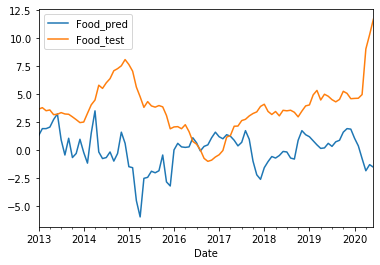

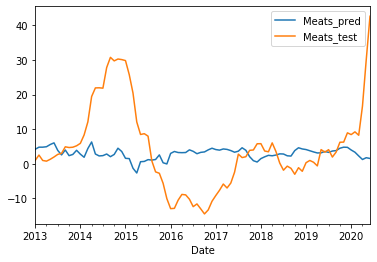

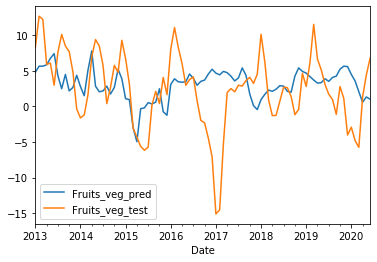

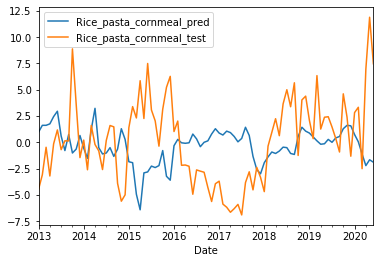

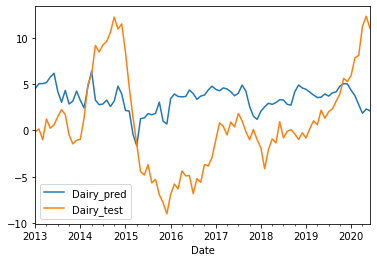

In [26]:
resultsdf[['Food_pred','Food_test']].plot()
resultsdf[['Meats_pred','Meats_test']].plot()
resultsdf[['Fruits_veg_pred','Fruits_veg_test']].plot()
resultsdf[['Rice_pasta_cornmeal_pred','Rice_pasta_cornmeal_test']].plot()
resultsdf[['Dairy_pred','Dairy_test']].plot()

In [27]:
Foodres = (resultsdf['Food_pred'] - resultsdf['Food_test'])**2
Meatsres = (resultsdf['Meats_pred'] - resultsdf['Meats_test'])**2
Fruits_veg_res = (resultsdf['Fruits_veg_pred'] - resultsdf['Fruits_veg_test'])**2
Rice_pasta_cornmeal_res = (resultsdf['Rice_pasta_cornmeal_pred'] - resultsdf['Rice_pasta_cornmeal_test'])**2
Dairyres = (resultsdf['Dairy_pred'] - resultsdf['Dairy_test'])**2

In [28]:
# check the different lags
lags_food = {}
for j in range(1, 20):
    OLSModel_food_lag = sm.OLS(FF3['Food'].iloc[j:360+j].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print('Lags' + str(j))
    print(OLSModel_food_lag.summary())
    y_pred = OLSModel.predict(FF3[['const','Ethanol']].iloc[360:-j])
    y_test = FF3['Food'].iloc[360+j:]
    residuals = (y_pred - y_test)**2
    mean_squared_deviation = np.mean(residuals)
    lags_food[j] = (mean_squared_deviation, OLSModel_food_lag.rsquared)

Lags1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     15.08
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           0.000123
Time:                        14:31:16   Log-Likelihood:                -820.66
No. Observations:                 360   AIC:                             1645.
Df Residuals:                     358   BIC:                             1653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5252      0.125     36.155   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     23.43
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           1.93e-06
Time:                        14:31:16   Log-Likelihood:                -812.09
No. Observations:                 360   AIC:                             1628.
Df Residuals:                     358   BIC:                             1636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5564      0.122     37.281      0.0

In [29]:
# check for lowest mean squared deviation, which in this case appears to be at lag 3, though the highest R2 is at lag 6
lags_food

{1: (8.180763636229587, 0.040410495540354474),
 2: (7.547453135191119, 0.06403852734935078),
 3: (7.025695952433164, 0.08771452428252324),
 4: (7.096274947489326, 0.1072382575820976),
 5: (7.183086788942885, 0.11973120454120356),
 6: (7.260507194328177, 0.12043558435576784),
 7: (7.445988082955336, 0.11304845857511947),
 8: (7.643360549316602, 0.10672047671445506),
 9: (7.838496999545779, 0.09299835333087558),
 10: (8.054385652676435, 0.07668726123631331),
 11: (8.287121929569917, 0.06142766312547043),
 12: (8.484564980177055, 0.04566447050995581),
 13: (8.726620530925082, 0.03316936396869841),
 14: (8.93904516036492, 0.02296027457724792),
 15: (9.20923063338903, 0.016939821169504876),
 16: (9.415423318213193, 0.012833291016443815),
 17: (9.590157892732694, 0.008722071013153254),
 18: (9.771057693858166, 0.005269204016652651),
 19: (9.91055552501685, 0.0035619896204275303)}

In [30]:
# I will try the same technique for Meats
lags_meat = {}
for j in range(0, 20):
    OLSModel_meat_lag = sm.OLS(FF3['Meats'].iloc[j:360+j].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print('Lags' + str(j))
    print(OLSModel_meat_lag.summary())
    y_pred = OLSModel.predict(FF3[['const','Ethanol']].iloc[360:-j])
    y_test = FF3['Meats'].iloc[360+j:]
    residuals = (y_pred - y_test)**2
    mean_squared_deviation = np.mean(residuals)
    lags_meat[j] = (mean_squared_deviation, OLSModel_meat_lag.rsquared)

Lags0
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     24.89
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           9.47e-07
Time:                        14:31:16   Log-Likelihood:                -1144.4
No. Observations:                 360   AIC:                             2293.
Df Residuals:                     358   BIC:                             2301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2958      0.308     13.966   

Lags11
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     16.68
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           5.46e-05
Time:                        14:31:16   Log-Likelihood:                -1141.8
No. Observations:                 360   AIC:                             2288.
Df Residuals:                     358   BIC:                             2295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4147      0.305     14.454  

In [31]:
# the lowest mean squared deviation is at lag 2, but the hightest R2 is at lag 5
lags_meat

{0: (nan, 0.0650168318379144),
 1: (140.37498843388173, 0.08932098689265655),
 2: (134.3960170890434, 0.11384954477961662),
 3: (134.6628786415606, 0.13480762653546008),
 4: (137.32016965361254, 0.15281914652734663),
 5: (140.1086556824217, 0.15800731404718138),
 6: (143.24439159766962, 0.14928142328143768),
 7: (146.77195244943098, 0.13190852818645582),
 8: (150.71264382639666, 0.1087821594059818),
 9: (154.85441721746696, 0.08661051594610591),
 10: (159.20949073819347, 0.06583853378032467),
 11: (163.78688007118683, 0.04452306543506901),
 12: (168.72395539445282, 0.021983204177970617),
 13: (173.8609930885275, 0.006434138260819289),
 14: (178.8373506224968, 0.00016002369021361762),
 15: (183.57991496096895, 0.002594450185780972),
 16: (186.76401040794082, 0.013185438588722898),
 17: (186.8788355096285, 0.030064642009616338),
 18: (186.47513022523813, 0.0468691590553727),
 19: (185.64551794007923, 0.05989638656952134)}

In [32]:
# I will try the same technique for Fruits_veg
lags_fruits = {}
for j in range(1, 20):
    OLSModel_fruit_lag = sm.OLS(FF3['Fruits_veg'].iloc[j:360+j].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print('Lags' + str(j))
    print(OLSModel_fruit_lag.summary())
    y_pred = OLSModel.predict(FF3[['const','Ethanol']].iloc[360:-j])
    y_test = FF3['Fruits_veg'].iloc[360+j:]
    residuals = (y_pred - y_test)**2
    mean_squared_deviation = np.mean(residuals)
    lags_fruits[j] = (mean_squared_deviation, OLSModel_fruit_lag.rsquared)

Lags1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     27.79
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           2.34e-07
Time:                        14:31:16   Log-Likelihood:                -1183.7
No. Observations:                 360   AIC:                             2371.
Df Residuals:                     358   BIC:                             2379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1371      0.343     17.889   

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
Lags12
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.05949
Date:                Mon, 07 Sep 2020   Prob (F-statistic):              0.807
Time:                        14:31:17   Log-Likelihood:                -1193.3
No. Observations:                 360   AIC:                             2391.
Df Residuals:                     358   BIC:                             2398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [33]:
len(FF3[['const','Ethanol']].iloc[361:])

89

In [34]:
# lag 8 has lowed mean squared deviation but lag 4 has highest R2
lags_fruits

{1: (28.015112827319648, 0.07204337616958911),
 2: (27.890391222671575, 0.07050061976769073),
 3: (27.911494265797394, 0.08316851555651106),
 4: (27.75671927275623, 0.09480115976618475),
 5: (27.587594977222643, 0.08561954508362413),
 6: (27.53804527884412, 0.050026491879664126),
 7: (27.055619778311367, 0.021644313218659228),
 8: (26.864676376317217, 0.010994673249615894),
 9: (27.29865589144167, 0.004337108043326321),
 10: (27.3334595334694, 0.0010255364257872879),
 11: (27.96103751491957, 5.600738061539712e-05),
 12: (28.46914080159223, 0.00016613393530928722),
 13: (29.025274982420054, 0.0027005421810625263),
 14: (29.732369300767324, 0.00729759170169153),
 15: (30.400506414875125, 0.009381815896758128),
 16: (30.350213501327165, 0.007019376041749736),
 17: (30.617582331962666, 0.0021051546635295626),
 18: (31.04113104200557, 1.3280862362852197e-05),
 19: (32.03555853732649, 0.003576518525264971)}

In [35]:
# I will try the same technique for Rice
lags_rice = {}
for j in range(1, 20):
    OLSModel_rice_lag = sm.OLS(FF3['Rice_pasta_cornmeal'].iloc[j:360+j].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print('Lags' + str(j))
    print(OLSModel_rice_lag.summary())
    y_pred = OLSModel.predict(FF3[['const','Ethanol']].iloc[360:-j])
    y_test = FF3['Rice_pasta_cornmeal'].iloc[361+j:]
    residuals = (y_pred - y_test)**2
    mean_squared_deviation = np.mean(residuals)
    lags_rice[j] = (mean_squared_deviation, OLSModel_rice_lag.rsquared)

Lags1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.049
Date:                Mon, 07 Sep 2020   Prob (F-statistic):             0.0816
Time:                        14:31:17   Log-Likelihood:                -1279.8
No. Observations:                 360   AIC:                             2564.
Df Residuals:                     358   BIC:                             2571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5778      0.448     10.218   

Lags12
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.555
Date:                Mon, 07 Sep 2020   Prob (F-statistic):              0.111
Time:                        14:31:17   Log-Likelihood:                -1278.5
No. Observations:                 360   AIC:                             2561.
Df Residuals:                     358   BIC:                             2569.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6584      0.446     10.434  

In [36]:
# lag 4 has lowest mean squared dev, lag 6 has the highest r2
lags_rice

{1: (29.829772050205, 0.008445286129984075),
 2: (29.040227934184703, 0.024146603903545394),
 3: (28.571499352700418, 0.04278803625120908),
 4: (28.56402443930508, 0.06024960803514601),
 5: (28.9854646698811, 0.07356726108842648),
 6: (29.43396818148989, 0.07650668570474395),
 7: (29.623705255885913, 0.06607981629287141),
 8: (30.135121852056066, 0.052639619047348596),
 9: (30.41867587676835, 0.04154484779056655),
 10: (30.95109059410845, 0.027124049529857697),
 11: (31.25109051692982, 0.013713754290929692),
 12: (32.036705446831526, 0.0070851211825394556),
 13: (32.67752372166361, 0.003112590093773182),
 14: (33.59666314942123, 0.0003035696657525122),
 15: (33.948109988855315, 0.0009587369155247272),
 16: (34.75031130145738, 0.00558304370010021),
 17: (35.321591421718956, 0.008557562278066588),
 18: (36.46211722634754, 0.008715594429433593),
 19: (37.85380296374133, 0.005480486464120138)}

In [37]:
# I will try the same technique for Dairy
lags_dairy = {}
for j in range(1, 20):
    OLSModel_dairy_lag = sm.OLS(FF3['Dairy'].iloc[j:360+j].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print('Lags' + str(j))
    print(OLSModel_fruit_lag.summary())
    y_pred = OLSModel.predict(FF3[['const','Ethanol']].iloc[360:-j])
    y_test = FF3['Dairy'].iloc[360+j:]
    residuals = (y_pred - y_test)**2
    mean_squared_deviation = np.mean(residuals)
    lags_dairy[j] = (mean_squared_deviation, OLSModel_dairy_lag.rsquared)

Lags1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.285
Date:                Mon, 07 Sep 2020   Prob (F-statistic):              0.258
Time:                        14:31:17   Log-Likelihood:                -1193.1
No. Observations:                 360   AIC:                             2390.
Df Residuals:                     358   BIC:                             2398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3116      0.352     17.924   

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
Lags11
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.285
Date:                Mon, 07 Sep 2020   Prob (F-statistic):              0.258
Time:                        14:31:17   Log-Likelihood:                -1193.1
No. Observations:                 360   AIC:                             2390.
Df Residuals:                     358   BIC:                             2398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [38]:
# lag 3 has lowest Mean Squared Dev, lag 2 has highest r2
lags_dairy

{1: (31.082705287893887, 0.07933619172140638),
 2: (30.301066413336628, 0.09309370820659679),
 3: (29.47709002835545, 0.09053643857202787),
 4: (29.635938291528287, 0.07728861119265018),
 5: (29.777241923096057, 0.06442003625206083),
 6: (30.110735767787293, 0.05587972469718305),
 7: (30.818695547982998, 0.04387384299827701),
 8: (31.640678357456324, 0.027249997759799305),
 9: (32.433040401486195, 0.012733845653284614),
 10: (33.21838416670707, 0.004256279545421737),
 11: (33.88585657957348, 0.00138582635398099),
 12: (34.488472140908286, 0.0007481881482453989),
 13: (35.23720843098911, 0.0009258560803541149),
 14: (36.34316930365278, 0.0016881029826120164),
 15: (37.43153289291332, 0.004546479683446236),
 16: (38.60973564334686, 0.009785496634821533),
 17: (39.06382540240746, 0.013849192535845822),
 18: (39.375072867535195, 0.014448759814602585),
 19: (39.61802705668522, 0.013659841293124364)}

In [39]:
# based on these observations, I am going to run the original model but with a lag of 5 months
# create empty lists to populate a results Data Frame with the predicted results, the test results and the residuals
el5 = []
la5 = []
res5 = []
r_25 = []
for i in FFts.columns:
    fr5 = str(i) + '_pred'
    ie5 = str(i) + '_test'
    nd5 = str(i) + '_residuals'
    r25 = str(i) + '_r2'
    el5.append(fr5)
    la5.append(ie5)
    res5.append(nd5)
    r_25.append(r25)
resultsd_5lag = {}
for i in range(2,7):
    OLSModel = sm.OLS(FF3.iloc[5:365,i].values,FF3[['const','Ethanol']].iloc[:360].values).fit()
    print(el5[i])
    print(OLSModel.summary())
    y_pred = OLSModel.predict(FF3[['Ethanol','const']].iloc[360:-5].values)
    resultsd_5lag[el5[i]] = y_pred
    resultsd_5lag[la5[i]] = FF3.iloc[365:,i]
    resultsd_5lag[res5[i]] = (y_pred - FF3.iloc[365:,i])
    resultsd_5lag[r_25[i]] = OLSModel.rsquared

Meats_pred
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     67.18
Date:                Mon, 07 Sep 2020   Prob (F-statistic):           4.46e-15
Time:                        14:31:18   Log-Likelihood:                -1126.0
No. Observations:                 360   AIC:                             2256.
Df Residuals:                     358   BIC:                             2264.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2140      0.292     14.4

In [40]:
resultsdf_5mnth_lag = pd.DataFrame(resultsd_5lag)

In [41]:
resultsdf_5mnth_lag.head(15)

,Meats_pred,Meats_test,Meats_residuals,Meats_r2,Food_pred,Food_test,Food_residuals,Food_r2,Fruits_veg_pred,Fruits_veg_test,Fruits_veg_residuals,Fruits_veg_r2,Rice_pasta_cornmeal_pred,Rice_pasta_cornmeal_test,Rice_pasta_cornmeal_residuals,Rice_pasta_cornmeal_r2,Dairy_pred,Dairy_test,Dairy_residuals,Dairy_r2
Date,,,,,,,,,,,,,,,,,,,,
2013-06-01 00:00:00+00:00,6.254537,1.945,4.309537,0.158007,2.511860,3.229,-0.717140,0.119731,5.414548,2.964,2.450548,0.08562,6.066636,1.185,4.881636,0.073567,4.746425,0.577,4.169425,0.06442
2013-07-01 00:00:00+00:00,6.844500,2.696,4.148500,0.158007,3.144556,3.371,-0.226444,0.119731,6.290680,7.600,-1.309320,0.08562,6.699085,-0.689,7.388085,0.073567,5.283708,1.486,3.797708,0.06442
2013-08-01 00:00:00+00:00,6.844500,2.989,3.855500,0.158007,3.144556,3.250,-0.105444,0.119731,6.290680,10.107,-3.816320,0.08562,6.699085,0.152,6.547085,0.073567,5.283708,2.242,3.041708,0.06442
2013-09-01 00:00:00+00:00,6.970920,4.888,2.082920,0.158007,3.280134,3.224,0.056134,0.119731,6.478423,8.488,-2.009577,0.08562,6.834610,0.138,6.696610,0.073567,5.398840,1.696,3.702840,0.06442
2013-10-01 00:00:00+00:00,7.603023,4.682,2.921023,0.158007,3.958024,2.993,0.965024,0.119731,7.417136,7.702,-0.284864,0.08562,7.512235,8.888,-1.375765,0.073567,5.974500,-0.487,6.461500,0.06442
2013-11-01 00:00:00+00:00,8.066566,4.771,3.295566,0.158007,4.455143,2.745,1.710143,0.119731,8.105526,4.828,3.277526,0.08562,8.009159,3.620,4.389159,0.073567,6.396651,-1.458,7.854651,0.06442
2013-12-01 00:00:00+00:00,5.917415,5.184,0.733415,0.158007,2.150319,2.479,-0.328681,0.119731,4.913901,-0.380,5.293901,0.08562,5.705236,-1.445,7.150236,0.073567,4.439407,-1.067,5.506407,0.06442
2014-01-01 00:00:00+00:00,4.653209,5.885,-1.231791,0.158007,0.794540,2.531,-1.736460,0.119731,3.036474,-1.619,4.655474,0.08562,4.349987,0.220,4.129987,0.073567,3.288087,-0.957,4.245087,0.06442
2014-02-01 00:00:00+00:00,6.043836,8.318,-2.274164,0.158007,2.285896,3.307,-1.021104,0.119731,5.101644,-1.202,6.303644,0.08562,5.840761,-2.600,8.440761,0.073567,4.554539,1.335,3.219539,0.06442


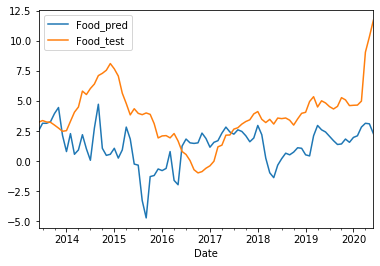

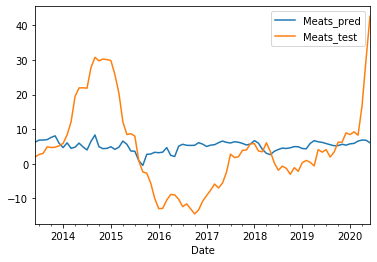

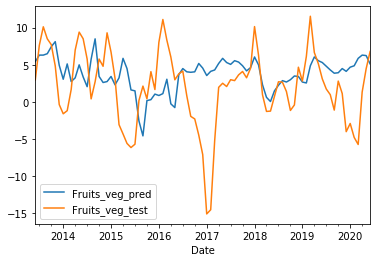

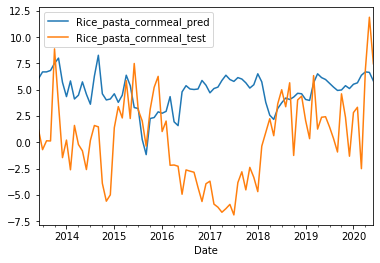

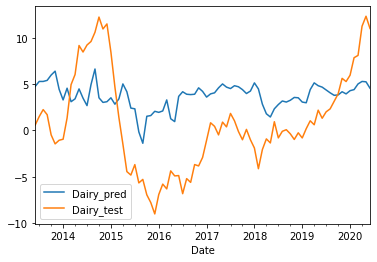

In [42]:
resultsdf_5mnth_lag[['Food_pred','Food_test']].plot()
resultsdf_5mnth_lag[['Meats_pred','Meats_test']].plot()
resultsdf_5mnth_lag[['Fruits_veg_pred','Fruits_veg_test']].plot()
resultsdf_5mnth_lag[['Rice_pasta_cornmeal_pred','Rice_pasta_cornmeal_test']].plot()
resultsdf_5mnth_lag[['Dairy_pred','Dairy_test']].plot()

In [43]:
# It appears that the impact of Ethanol prices is not high for any of the food categories. I will use the Dicky Fuller test for cointegration to see if each timeseries is a random walk, and if the spread between them is also a random walk.
result = sm.OLS(FF3['Food'].values,FF3[['const','Ethanol']].values).fit()
b = result.params[1]
adf_stats = adfuller(FF3['Food'] - b*FF3['Ethanol'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  2.4057890218060543e-05


In [44]:
# Compute the ADF for Ethanol and Food
result_Ethanol = adfuller(FF1['Ethanol'])
print("The p-value for the ADF test on Ethanol is ", result_Ethanol[1])
result_Food = adfuller(FF1['Food'])
print("The p-value for the ADF test on Food is ", result_Food[1])

# Compute the ADF of the spread
result_spread = adfuller(FF1.Ethanol - FF1.Food)
print("The p-value for the ADF test on the spread is ", result_spread[1])
# It looks like the p value is not small enough to reject the null hypothesis - both time series as well as the spread appear to be random walks

The p-value for the ADF test on Ethanol is  0.23973639306627387
The p-value for the ADF test on Food is  0.9951246079893528
The p-value for the ADF test on the spread is  0.9955322577633365


In [45]:
# Compute the ADF for Ethanol and Meats
result_Ethanol = adfuller(FF1['Ethanol'])
print("The p-value for the ADF test on Ethanol is ", result_Ethanol[1])
result_Meats = adfuller(FF1['Food'])
print("The p-value for the ADF test on Meats is ", result_Meats[1])

# Compute the ADF of the spread
result_spread = adfuller(FF1.Ethanol - FF1.Meats)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on Ethanol is  0.23973639306627387
The p-value for the ADF test on Meats is  0.9951246079893528
The p-value for the ADF test on the spread is  0.997254308316507


In [46]:
for i in FF2.columns[1:]:
    # Compute the ADF for Ethanol and i
    result_i = adfuller(FF2[i])
    print("The p-value for the ADF test on ", str(i), result_i[1])

    # Compute the ADF of the spread
    result_spread = adfuller(FF2.Ethanol - FF2[i])
    print("The p-value for the ADF test on the spread for ", str(i), result_spread[1])

The p-value for the ADF test on  Meats 0.9971204025288364
The p-value for the ADF test on the spread for  Meats 0.997254308316507
The p-value for the ADF test on  Food 0.9951246079893528
The p-value for the ADF test on the spread for  Food 0.9955322577633365
The p-value for the ADF test on  Fruits_veg 0.4551855464818659
The p-value for the ADF test on the spread for  Fruits_veg 0.4459142147022027
The p-value for the ADF test on  Rice_pasta_cornmeal 0.9428272188043408
The p-value for the ADF test on the spread for  Rice_pasta_cornmeal 0.9377946380210289
The p-value for the ADF test on  Dairy 0.8630130679295067
The p-value for the ADF test on the spread for  Dairy 0.8664720798188803


In [47]:
# calculate for lag of 5 months
for i in FF2.columns[1:]:
    # Compute the ADF for Ethanol and i
    result_i = adfuller(FF2[i].iloc[5:].values)
    print("The p-value for the ADF test on ", str(i), result_i[1])

    # Compute the ADF of the spread
    result_spread = adfuller(FF2.Ethanol.iloc[:-5].values - FF2[i].iloc[5:].values)
    print("The p-value for the ADF test on the spread is ", result_spread[1])
result_Ethanol = adfuller(FF1['Ethanol'].iloc[:-5].values)
print("The p-value for the ADF test on Ethanol is ", result_Ethanol[1])

The p-value for the ADF test on  Meats 0.9965972770234471
The p-value for the ADF test on the spread is  0.9968128956048335
The p-value for the ADF test on  Food 0.9935910515017619
The p-value for the ADF test on the spread is  0.9946662657461242
The p-value for the ADF test on  Fruits_veg 0.4444435701556615
The p-value for the ADF test on the spread is  0.4251589416985596
The p-value for the ADF test on  Rice_pasta_cornmeal 0.9317906901764842
The p-value for the ADF test on the spread is  0.9194871459456263
The p-value for the ADF test on  Dairy 0.8573871976701534
The p-value for the ADF test on the spread is  0.8615560368097147
The p-value for the ADF test on Ethanol is  0.19365406979748906
